# Linear Regression - Ordinary Least Squares (OLS)  


There are two very different algorithms or approaches for implementing the Linear Regression model.
    - The “closed-form” solution approach known as the Ordinary Least Squares (OLS) method.
    - Iterative optimization approach known as the Gradient Descent (GD).
    

We will perform an extensive investigation of these two approaches using **Scikit-Learn** in a series of four notebooks. For this exploration we will use the Boston Housing dataset that has 506 samples and 13 features.


## Index for the Notebook Series on Scikit-Learn Solutions for Linear Regression

There are four notebooks on the sklearn-based Linear Regression.

1. Linear Regression-1-OLS
        -- OLS method & Regularized OLS Method (Ridge Rergression)
2. Linear Regression-2-OLS Polynomial Regression-Frequentist Approach (MLE)
        -- Polynomial regression using the OLS method
3. Linear Regression-3-OLS Polynomial Regression-Bayesian Approach (MAP)
        -- Polynomial regression using the regularized OLS method
4. Linear Regression-4-Gradient Descent
        -- Iterative optimization approach (Gradient Descent & Stochastic Gradient Descent)
5. Linear Regression-5-Polynomial SGD Regressor Model Selection
        -- Perform model selection when using Stochastic Gradient Descent (SGD) algorithm for a Polynomial Regression Model


## Complexity of the Solution Approaches


#### Closed-form Solution (OLS Method)
The OLS method computes the inverse of $X^TX$, which is a $(d+1) × (d+1)$ matrix (where d is the number of features). 
The computational complexity of inverting such a matrix is typically about $O(d^{2.4})$ to $O(d^3)$ (depending on the implementation). 

- Limitations: 

        -- The OLS method gets very slow when the number of features are large (e.g., 100,000).
    
        -- It requires the entire dataset to be stored in the memory.

- When Should We Use the OLS Method?

This method is linear with regards to the number of instances in the training set (it is $O(n)$).
So, it handles large training sets efficiently, provided they can fit in memory.
Generally, we should use the OLS method when the **dataset is not large (can be stored in memory) and  the number of features is not large**.


#### Gradient Descent Approach

We explore two variants of the GD approach: Batch GD and Stochastic GD (SGD). There is yet another variant known as mini-batch GD.

    Batch Gradient Descent: 
It uses the whole batch of training data at every step. As a result it is terribly slow on very large training sets. 

- When Should We Use the Batch GD?

Gradient Descent scales well with the number of features. Thus, we should use it when the **dataset is not too large and there are hundreds of thousands of features**.



    Stochastic Gradient Descent:
It picks a random instance in the training set at every step and computes the gradients based only on that single instance. It makes the algorithm much faster since it has very little data to manipulate at every iteration. 

- When Should We Use the SGD?

We should use the SGD when we need to train huge training sets. Also, SGD can be implemented as an out-of-core algorithm.


## High-Level Summary (A Pragmatic Guideline)

- Determine the level of complexity of pattern in the dataset.
    
      -- Generate the degree vs. RMSE curve (see notebook 2) and determine the optimal complexity (polynomial degree) of the model
    
- Implement the regularized polynomial regression (using the optimal degree).
    
      -- Use the regularized OLS method if dataset and feature set is not too large (notebook 3)
    
      -- Use the regularized GD approach otherwise (notebook 4 & 5)


***************************************************************************************************************


In this notebook, we implement sklearn's OLS Linear Regression model.



## OLS Method




<font color=red size=3> **Application Scenario:**</font> 
The OLS method is suitable for the following scenario.
- Dataset: not too large and fits into computer's memory
- No. of Features: not too large
- Relationship between input (features) and output (target): Linear


OLS is a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares:
    
    minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being predicted) in the given dataset and those predicted by the linear function.

OLS finds the optimal parameters by computing a closed-form solution for the **Normal equation**.

Previously we implemented the OLS method only by using NumPy library (see Linear Regression-1-Closed-Form Solution). In this notebook we will use the Scikit-Learn solutions.

URL: https://scikit-learn.org/stable/modules/linear_model.html#linear-model


## Dataset

URL: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

This dataset provides housing values in the suburbs of Boston.

The **MEDV** variable is the target variable.

### Data description

The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

- CRIM: per capita crime rate by town.

- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

- INDUS: proportion of non-retail business acres per town.

- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- NOX: nitrogen oxides concentration (parts per 10 million).

- RM: average number of rooms per dwelling.

- AGE: proportion of owner-occupied units built prior to 1940.

- DIS: weighted mean of distances to five Boston employment centres.

- RAD: index of accessibility to radial highways.

- TAX: full-value property-tax rate per $10,000.

- PTRATIO: pupil-teacher ratio by town.

- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

- LSTAT: lower status of the population (percent).

- MEDV: median value of owner-occupied homes in $1000s.

In [1]:
import warnings
import numpy as np
from numpy.linalg import matrix_rank
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

First load the data and explore the feature names, target names, etc.

In [2]:
# Load data
boston = datasets.load_boston()
print(boston.data.shape, boston.target.shape)
print(boston.feature_names)

(506, 13) (506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


## Create A DataFrame Object

In [3]:
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df = pd.concat([df,pd.Series(boston.target,name='MEDV')],axis=1)

# Quick Check of the Data

Let’s take a look at the top five rows using the DataFrame’s head() method.


In [4]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Description of the Data

DataFrame’s info() method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


# Dimension the Data

We need to know the dimension (number of rows and columns) of the data using DataFrame's shape method.

In [6]:
print("Dimension of the data: ", df.shape)

no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("No. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)

Dimension of the data:  (506, 14)
No. of Rows: 506
No. of Columns: 14


# Visualization of Data

Plot a histogram for each numerical attribute. 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18ad13c8>,
      dtype=object)

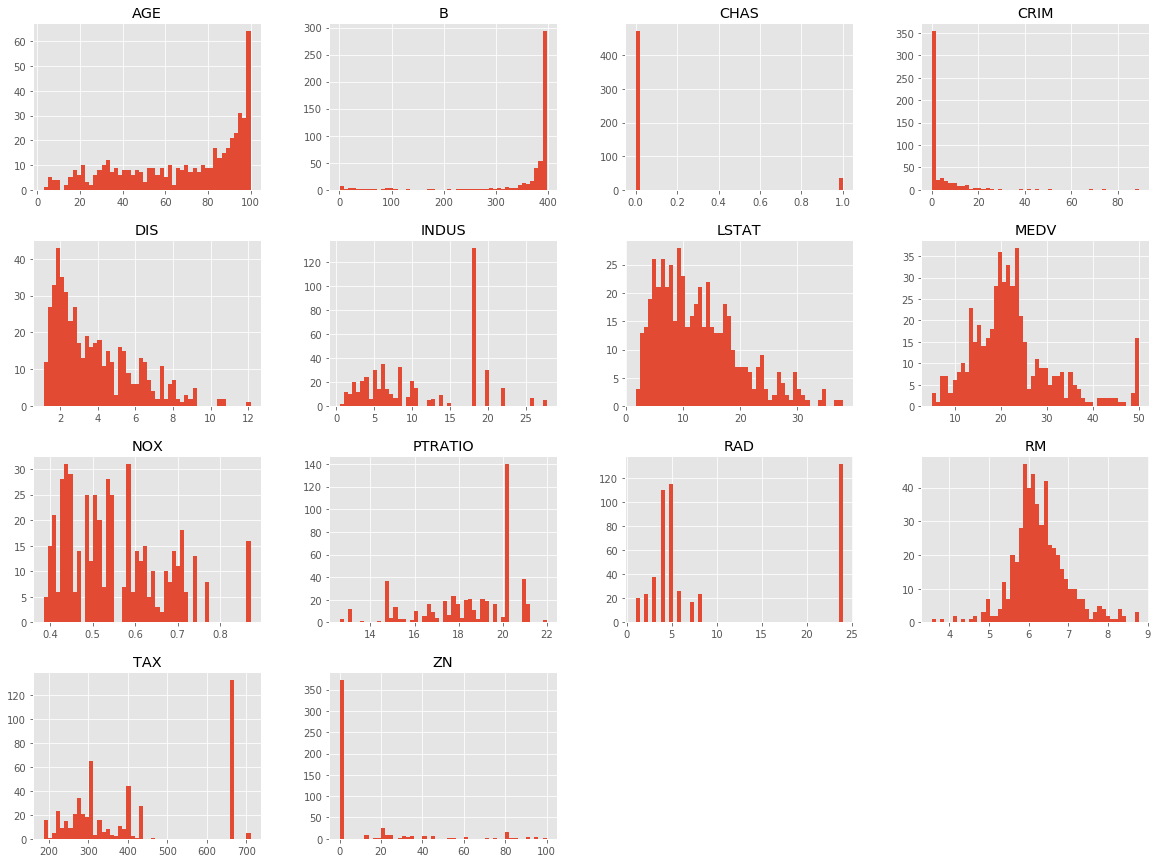

In [7]:
plt.style.use('ggplot')

df.hist(bins=50, figsize=(20,15)) 

# Visualize the Target Distribution


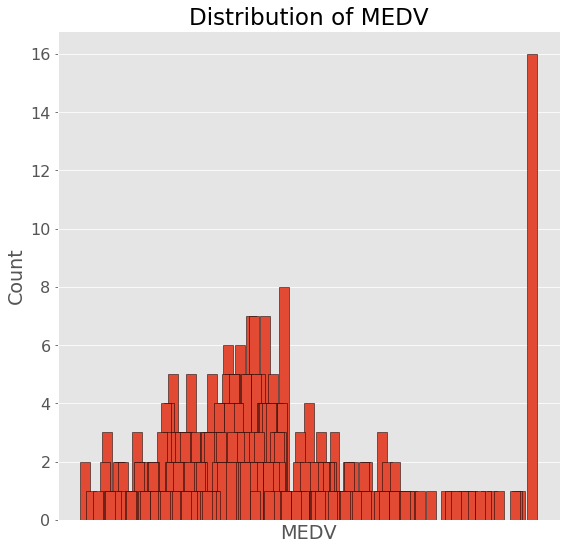

In [8]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (9, 9)

# Bar plot of grades
plt.bar(df['MEDV'].value_counts().index, 
        df['MEDV'].value_counts().values,
         fill = 'navy', edgecolor = 'k', width = 1)
plt.xlabel('MEDV'); 
plt.ylabel('Count'); 
plt.title('Distribution of MEDV');
plt.xticks(list(range(1, 1)));

# Explore The Target

In [9]:
df['MEDV'].value_counts()

50.0    16
25.0     8
23.1     7
21.7     7
22.0     7
20.6     6
19.4     6
20.1     5
19.6     5
19.3     5
15.6     5
21.4     5
13.8     5
21.2     5
20.0     5
17.8     5
23.9     5
22.6     5
22.2     5
24.4     4
23.2     4
23.8     4
19.1     4
20.3     4
13.4     4
19.9     4
27.5     4
22.8     4
22.9     4
18.9     4
        ..
12.3     1
37.6     1
29.4     1
12.6     1
22.1     1
31.1     1
48.3     1
26.2     1
11.0     1
9.5      1
12.0     1
17.7     1
44.8     1
35.1     1
32.4     1
42.3     1
28.2     1
31.2     1
33.3     1
37.2     1
28.6     1
15.1     1
17.3     1
6.3      1
39.8     1
12.8     1
29.9     1
9.6      1
36.1     1
13.0     1
Name: MEDV, Length: 229, dtype: int64

# Explore the Data: Describe Numerical Attributes

DataFrame's describe() method shows a summary of the numerical attributes.

In [10]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Check The Columns for Missing Data

In [11]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

# Looking for Numerical Correlations with the Target Column

Since the dataset is not too large, we can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using DataFrame's corr() method.


In [12]:
# Variable Correlations with the target "MEDV"

df.corr()['MEDV'].sort_values(ascending=False)

MEDV       1.000000
RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64

In [13]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


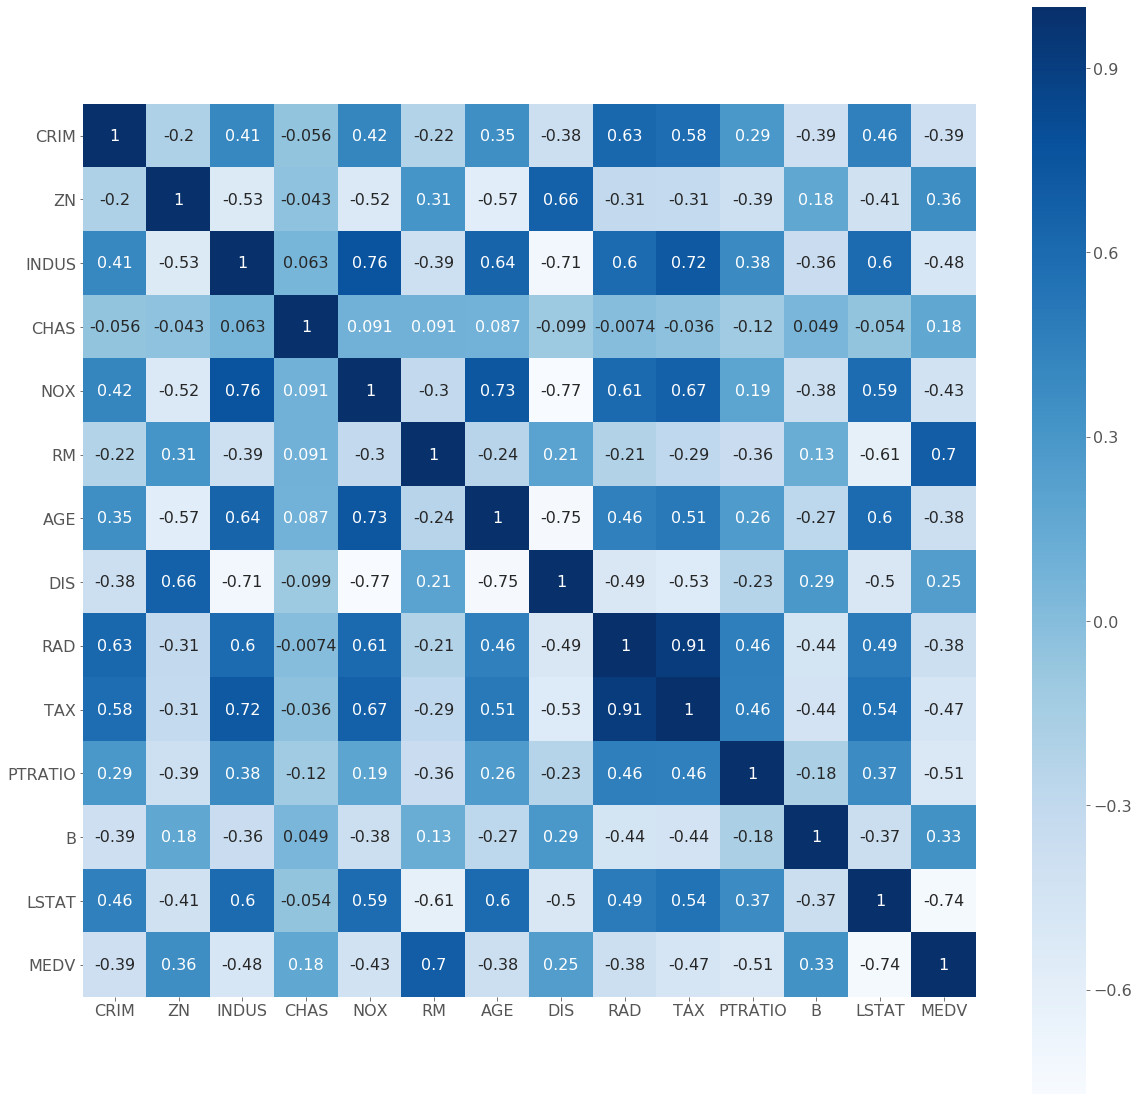

In [14]:
correlation = df.corr()

fig = plt.subplots(figsize=(20,20))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues')

# Pairs Plot of The Variables

A better way to visualize the correlation of the features is by generating the pairs plot. 

A pairs plot allows us to see both distribution of single variables and relationships between two variables. 


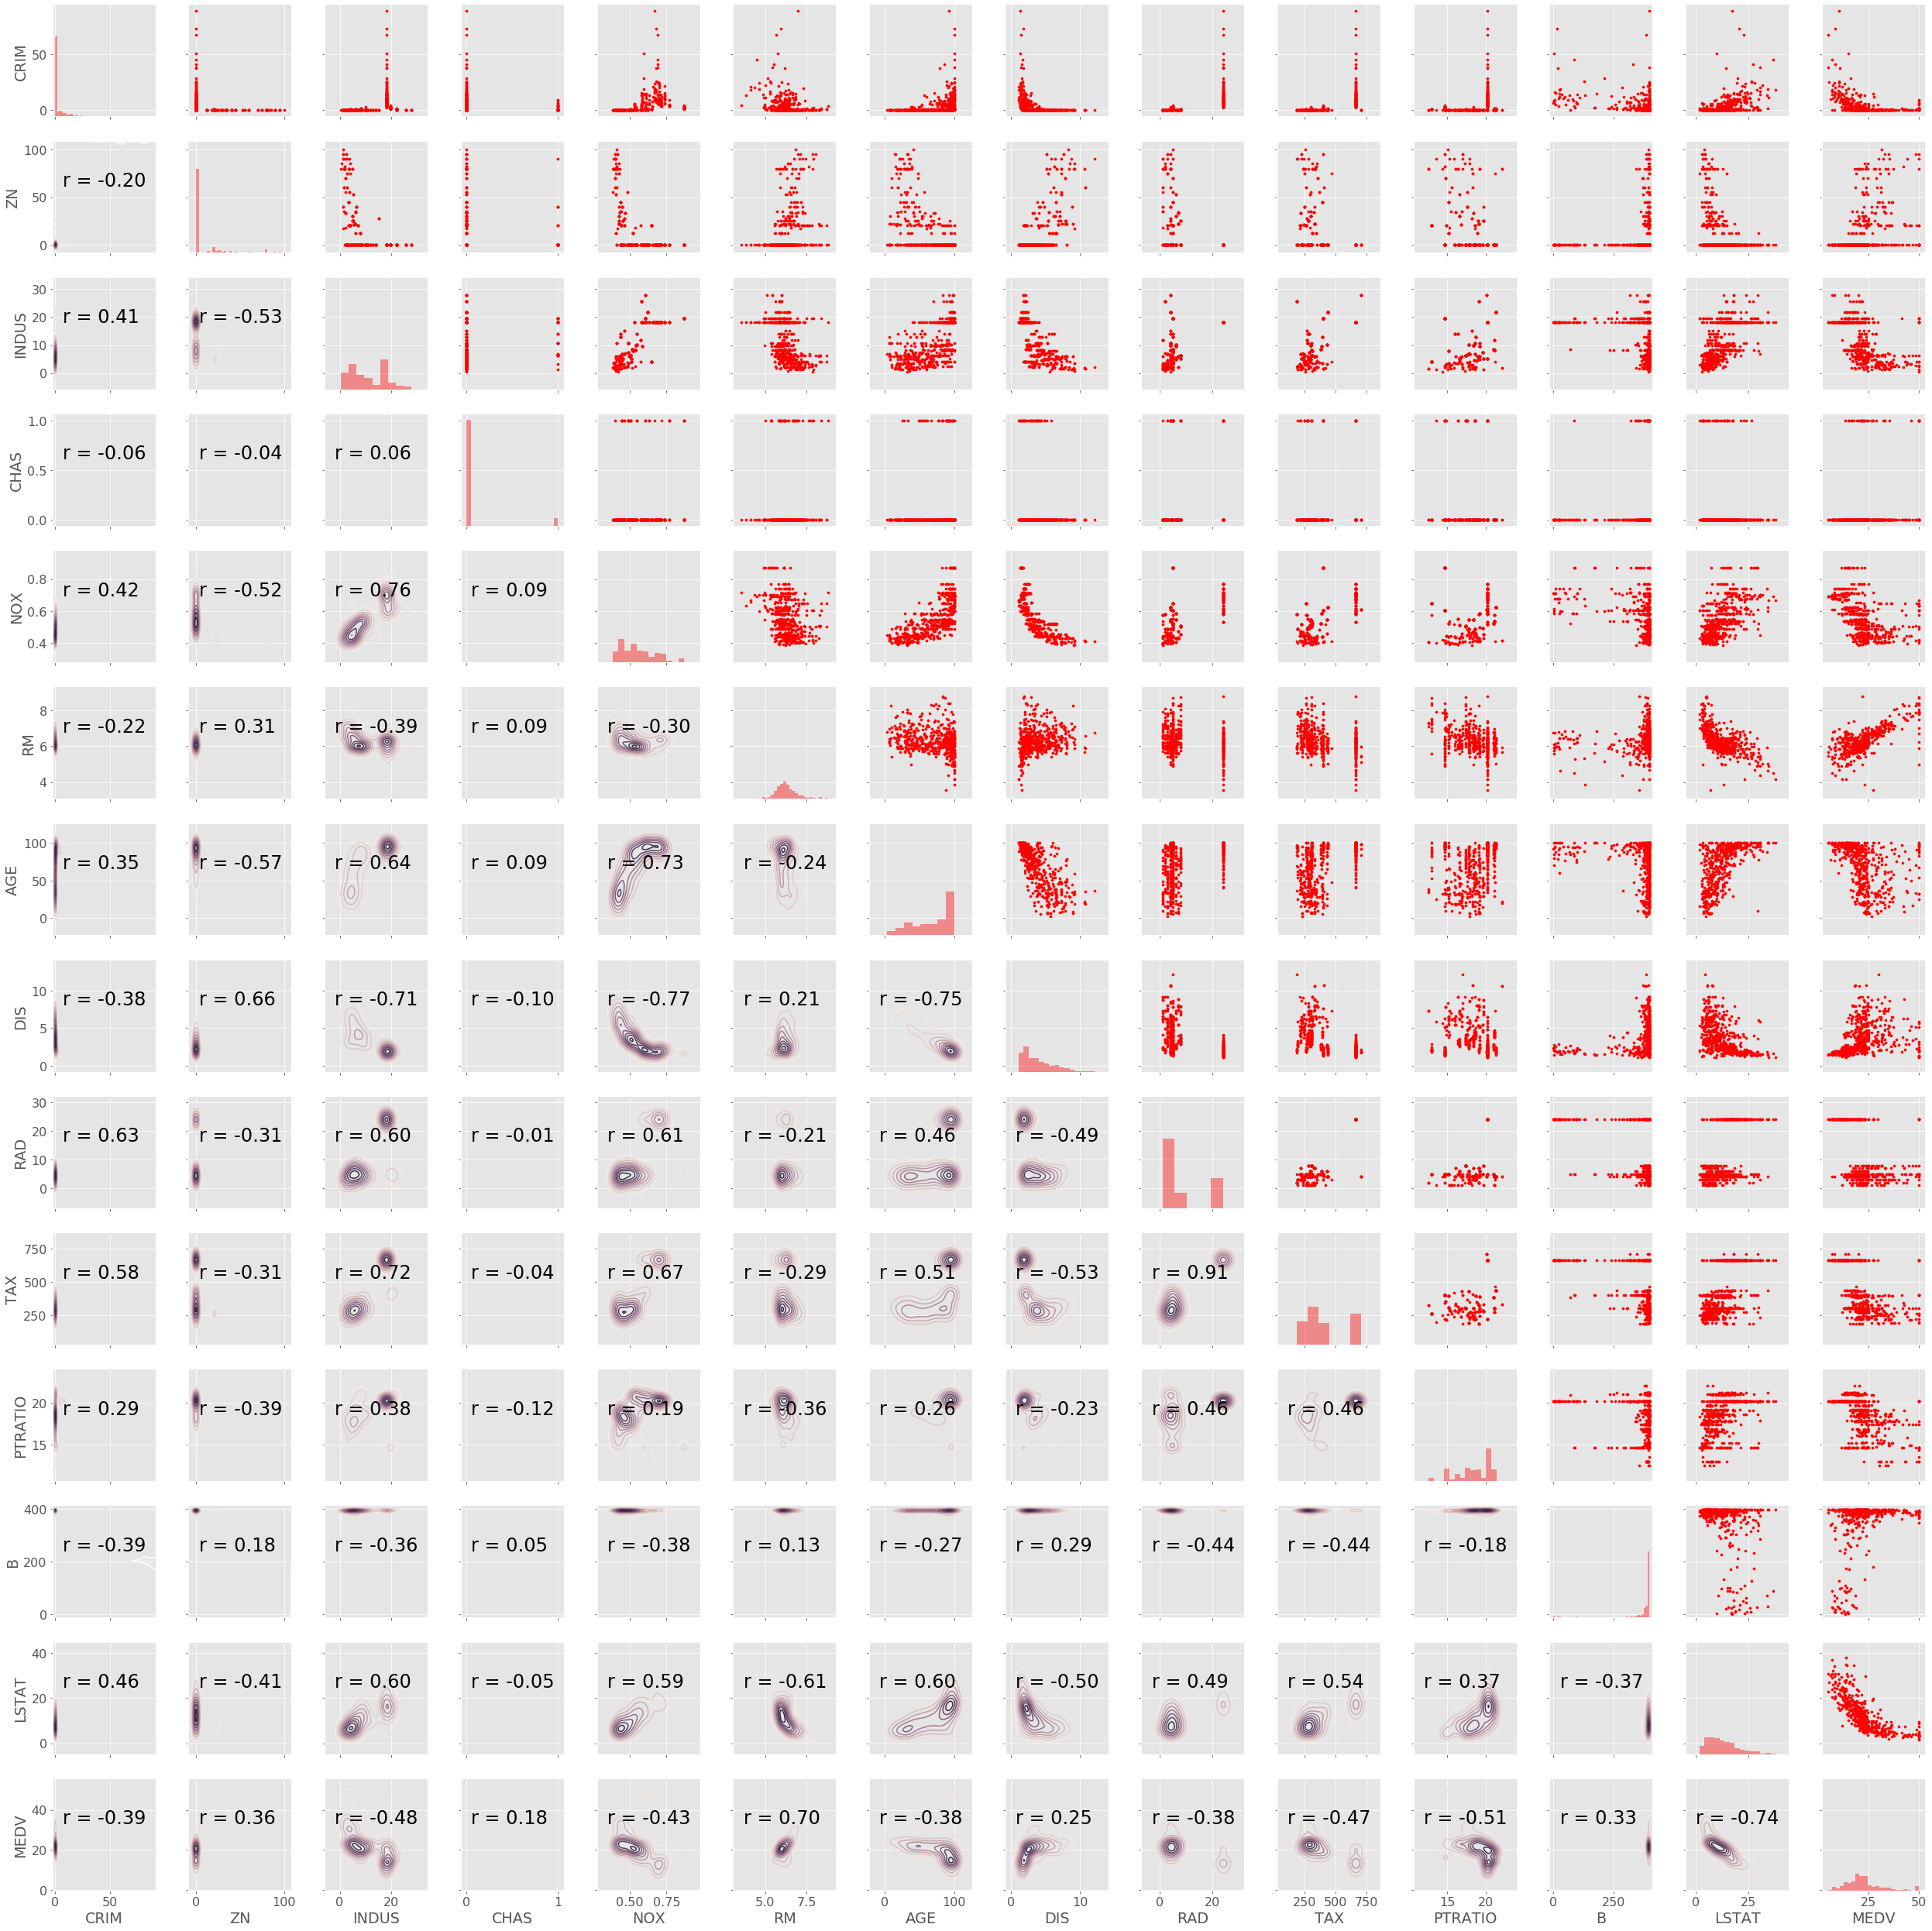

In [15]:
warnings.filterwarnings('ignore')

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

## Correlation

Notice that the target MEDV is highly correlated with the following features:
- LSTAT (-0.74)
- RM (0.70)

TAX and RAD has strong correlation (0.91). We may consider dropping "RAD". TAX has larger correlation with the target.

However, after some trial you will notice that the smallest mean squared error (mse) can be acieved without dropping any feature, i.e., by using all 13 features. 

### Thus, we will use <font color=red>ALL features</font> for training the model.

In [16]:
# Drop the redundant features


#df = df.drop(columns=['RAD'])

# Create a Separate Feature Set (Data Matrix X) and Target (1D Array y)

Create a data matrix (X) that contains all features and a 1D target array (y) containing the target.



In [17]:
# Make a deep copy of the data frame object. It contains all attributes (all features and the target)
allData = df.copy()

# Use the following code to select a subset of the features, e.g., "LSTAT"
#X = df[['LSTAT', 'RM']]

# Create separate data frame objects for X (features) and y (target)
X = df.drop(columns='MEDV')  
y = df['MEDV']


# Convert the Pandas data frame object X and y into numpy arrays.
X = np.asarray(X) # Data Matrix containing all features excluding the target
y = np.asarray(y) # 1D target array

print("X shape: ", X.shape)
print("y shape: ", y.shape)

print("\nX data type: ", X.dtype)
print("y data type: ", y.dtype)

X shape:  (506, 13)
y shape:  (506,)

X data type:  float64
y data type:  float64


## Determine Whether the Data Matrix X is Sigular 

If the data matrix is not full rank, then it will have collinearity.

In [18]:
print("Rank of X:", matrix_rank(X))

Rank of X: 13


# Create Train and Test Dataset

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Features

We should ensure that all features have a similar scale. Otherwise optimization algorithms (e.g., Gradient Descent based algorithms) will take much longer time to converge.

Also, regularization techniques are sensitive to the scale of data. Thus, we must scale the features before applying regularization.

In [20]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# OLS Method for Solving the Linear Regression Problem

We implement the following OLS methods for solving the Linear Regression problem.

- Ordinary Least Squares (OLS) method for Linear Regression (by solving the Normal Equation)
- Regularized OLS method for Linear Regression (also known as Ridge Regression)


### Regularization

Regularization is an effective technique for **reducing overfitting**.

For a linear model, regularization is typically achieved by constraining the weights of the model. We consider three different ways to constrain the weights.

- Ridge Regression ($l_2$ norm)
- Lasso Regression ($l_1$ norm)
- Elastic Net (it combines $l_1$ and $l_2$ priors as regularizer)

### Regularization: A Common Hyperparameter

In all regularization methods, we need to use the hyperparameter $\alpha$. It controls how much we want to regularize the model. 

- If $\alpha = 0$, then Ridge Regression is just Linear Regression. 
- If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. 


### When should we use the OLS methods (and regularized OLS methods)?

The OLS solution (by solving the Normal Equation) requires to store the entire dataset in memory. It is effective and a time-saving option when we work with a **small dataset that has small number of features**.

However, it gets very slow when the number of features grows large (e.g., 100,000). It's computational complexity is $O(n^3)$.

The **gradient descent** based methods are used when there are a large number of features, or too many training instances to fit in memory.


## Evaluation Metrics

We use two evaluation metrics.

- Mean Squared Error (MSE)
- Coefficient of Determination or $R^2$ or $r^2$


### Note on $R^2$:
R-squared is a statistical measure of how close the data are to the fitted regression line. 

R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

In general, the higher the R-squared, the better the model fits your data. 

#### Compute $R^2$ using the sklearn:

- The "score" function of the OLS Linear Regression object
- The "r2_score" function from sklearn.metrics

#### Compute MSE using the sklearn:

- The "mean_squared_error" function from sklearn.metrics


## Ordinary Least Squares (OLS) Linear Regression (by solving the Normal Equation)

Sklearn's LinearRegression() is used to implement the OLS solution.

In [21]:
# Create a OLS linear regression object
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)


# The intercept
print("Intercept: \n", lin_reg.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg.coef_)


print("\n----------------------------- Model Evaluation -----------------------------")


# Make prediction 
y_train_predicted = lin_reg.predict(X_train)


print("\nTraining: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted))


# To compute 

# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted))

# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % lin_reg.score(X_train, y_train))

Intercept: 
 22.796534653465375
Coefficients: 
 [-1.00213533  0.69626862  0.27806485  0.7187384  -2.0223194   3.14523956
 -0.17604788 -3.0819076   2.25140666 -1.76701378 -2.03775151  1.12956831
 -3.61165842]

----------------------------- Model Evaluation -----------------------------

Training: Mean squared error: 21.64
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.75
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.75


## Evaluate the Model Using Test Data - OLS Linear Regression

We evaluate the trained model on the test data.

The goal is to see how the model performs on the test data.

Later we will apply other Linear Regression models (e,g, polynomial, iterative optimization) on the data.

### Note:
We will see that none of the powerful models will improve the performance on the test data. Only the **polynomial** model will be able to make our model generalizable (see the "Linear Regression-Boston Housing-3, 4 & 5" notebooks). 

In short, we will see that only by increasing model complexity (higher-degree polynomial), we could improve performance on the test data.

In [22]:
# Make prediction 
y_test_predicted = lin_reg.predict(X_test)


print("Test: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))


# Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test: Mean squared error: 24.29
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.67


# Regularized OLS Models

There are two reasons why regularzied OLS method is preferable over the non-regularized OLS method.
    
    -- A model with some regularization typically performs better than a model without any regularization. Thus, we should generally prefer regularized Regression over plain Linear Regression.

    -- Moreover, the Normal Equation requires computing the inverse of a matrix, but that matrix is not always invertible. In contrast, the matrix for regularized Regression (e.g., Ridge Regression) is always invertible.

 We look at three different regularization OLS models.

- Ridge Regression ($l_2$ norm)
- Lasso Regression ($l_1$ norm)
- Elastic Net (combines $l_1$ and $l_2$ priors as regularizer)

## Ridge Regression

We implement the Ridge Regression with Scikit-Learn using a closed-form solution. It uses a matrix factorization technique by André-Louis **Cholesky**.

We need to set the following two hyperparameters of the Ridge regression model.

- alpha : {float, array-like}, shape (n_targets)
Regularization strength; must be a positive float. Regularization improves the conditioning of the problem and reduces the variance of the estimates. Larger values specify stronger regularization.

- solver : {‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’}

Three relevant solvers:
1. ‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution.
2. ‘sparse_cg’ uses the conjugate gradient solver as found in scipy.sparse.linalg.cg. As an iterative algorithm, this solver is more appropriate than ‘cholesky’ for large-scale data (possibility to set tol and max_iter).
3. ‘lsqr’ uses the dedicated regularized least-squares routine scipy.sparse.linalg.lsqr. It is the fastest and uses an iterative procedure.

         -- Default setting is ‘auto’: it chooses the solver automatically based on the type of data.


In [23]:
# Ridge Regression

# Regularization parameter
ridge_alpha = 1.0

# Create a Ridge linear regression object
lin_reg_ridge = Ridge(alpha=ridge_alpha)

# Train the model
lin_reg_ridge.fit(X_train, y_train)



# The intercept
print("Intercept: \n", lin_reg_ridge.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg_ridge.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_ridge.n_iter_)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_ridge = lin_reg_ridge.predict(X_train)


print("\nTraining: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_ridge))


# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_ridge))

Intercept: 
 22.796534653465375
Coefficients: 
 [-0.99218679  0.6777488   0.2522143   0.72248078 -1.99083465  3.15157218
 -0.17726162 -3.04502895  2.17324941 -1.69555879 -2.02783351  1.127197
 -3.59897667]
Number of Iterations: 
 None

----------------------------- Model Evaluation -----------------------------

Training: Mean squared error: 21.64
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.75


## Evaluate the Model Using Test Data - Ridge Regression

In [24]:
# Make prediction 
y_test_predicted = lin_reg_ridge.predict(X_test)

ridge_test_mse = mean_squared_error(y_test, y_test_predicted)

print("Test: Mean squared error: %.2f" % ridge_test_mse)


# Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test: Mean squared error: 24.31
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.67


## Lasso Regression


Least Absolute Shrinkage and Selection Operator (Lasso) Regression is another regularized version of Linear Regression.

Just like Ridge Regression, it adds a regularization term to the cost function, but it uses the $l_1$ norm of the weight vector instead of half the square of the $l_2$ norm. 


#### Questions to ponder:
- What is the impact of setting alpha to 1 or higher value?

We will use the same value of the regularization strength parameter (i.e., 1) that we used in Ridge regression. It will not produce optimal performance. Our goal is to see how the Lasso regression creates a sparse model.

In [25]:
# Lasso Regression

# Regularization parameter
lasso_alpha = 1.0

# Create a Lasso linear regression object
lin_reg_lasso = Lasso(alpha=lasso_alpha)


# Train the model
lin_reg_lasso.fit(X_train, y_train)



# The intercept
print("Intercept: \n", lin_reg_lasso.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg_lasso.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_lasso.n_iter_)


print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_lasso = lin_reg_lasso.predict(X_train)


print("\nTraining: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_lasso))


# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_lasso))

Intercept: 
 22.796534653465375
Coefficients: 
 [-0.01238985  0.         -0.          0.0384036  -0.          3.07945798
 -0.         -0.         -0.         -0.         -1.22090499  0.44979801
 -3.37659049]
Number of Iterations: 
 13

----------------------------- Model Evaluation -----------------------------

Training: Mean squared error: 27.99
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.68


## Evaluate the Model Using Test Data - Lasso Regression

In [26]:
# Make prediction 
y_test_predicted = lin_reg_lasso.predict(X_test)

lasso_test_mse = mean_squared_error(y_test, y_test_predicted)
print("Test: Mean squared error: %.2f" % lasso_test_mse)

# Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test: Mean squared error: 27.58
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.62


##  Ridge Regression vs. Lasso Regression


Lasso Regression uses an $l_1$ penalty, which tends to push the weights down to exactly zero. This leads to **<font color=red>sparse models</font>**, where all weights are zero except for the most important weights. This is a way to perform **feature selection** automatically, which is good if we suspect that only a few features actually matter. When we are not sure, we should prefer Ridge Regression.


## Comparison of the Weight Values: Ridge Regression vs. Lasso Regression

We will see that when the regularization coefficient (alpha) is large (e.g., $ \geq 1.0$), Lasso regression tends to drive the weight values towards 0.

In [27]:
print("%17s (alpha = %3.3f)  %10s (alpha = %3.3f)" % ("Ridge",ridge_alpha, "Lasso", lasso_alpha))
print("%17s MSE = %3.3f  %12s MSE = %3.3f" % (" ",ridge_test_mse, " ", lasso_test_mse))
print("________________________________________________________________\n")
for i in range(lin_reg_ridge.coef_.shape[0]):
    print("%8s: %15f  %30f" %(boston.feature_names[i], lin_reg_ridge.coef_[i], lin_reg_lasso.coef_[i]))
    

            Ridge (alpha = 1.000)       Lasso (alpha = 1.000)
                  MSE = 24.313               MSE = 27.578
________________________________________________________________

    CRIM:       -0.992187                       -0.012390
      ZN:        0.677749                        0.000000
   INDUS:        0.252214                       -0.000000
    CHAS:        0.722481                        0.038404
     NOX:       -1.990835                       -0.000000
      RM:        3.151572                        3.079458
     AGE:       -0.177262                       -0.000000
     DIS:       -3.045029                       -0.000000
     RAD:        2.173249                       -0.000000
     TAX:       -1.695559                       -0.000000
 PTRATIO:       -2.027834                       -1.220905
       B:        1.127197                        0.449798
   LSTAT:       -3.598977                       -3.376590


## Elastic Net 

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. 

The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and we can control the mix ratio by the "l1_ratio" mixing parameter. 

- When l1_ratio = 0, Elastic Net is equivalent to Ridge Regression ($l_2$ penalty)
- when l1_ratio = 1, it is equivalent to Lasso Regression ($l_1$ penalty)
- For 0 < l1_ratio < 1, the penalty is a combination of $l_1$ and $l_2$.


## Elastic Net vs. Lasso

Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). 

However, it does add an extra hyperparameter (l1_ratio) to tune. If we just want Lasso without the erratic behavior, we can use Elastic Net with an l1_ratio close to 1.


In [28]:
# Elastic Net Regression


# Create a elastic net linear regression object
lin_reg_enet = ElasticNet(alpha=0.0001, l1_ratio=0.5)

# Train the model
lin_reg_enet.fit(X_train, y_train)



# The intercept
print("Intercept: \n", lin_reg_enet.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg_enet.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_enet.n_iter_)

print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_enet = lin_reg_enet.predict(X_train)


print("\nTraining: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_enet))


# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_enet))

Intercept: 
 22.796534653465375
Coefficients: 
 [-1.00178977  0.69563441  0.2770682   0.71882375 -2.0213564   3.14540499
 -0.17596003 -3.08080067  2.24886776 -1.76461067 -2.03745494  1.12946048
 -3.611387  ]
Number of Iterations: 
 81

----------------------------- Model Evaluation -----------------------------

Training: Mean squared error: 21.64
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.75


## Evaluate the Model Using Test Data - Elastic Net Regression

In [29]:
# Make prediction 
y_test_predicted = lin_reg_enet.predict(X_test)


print("Test: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))


# Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test: Mean squared error: 24.29
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.67


## Model Selection: Regularized OLS Models (Ridge & Lasso)

Our goal is to find the optimal regularization model (Ridge or Lasso). Elastic Net is a mix of Ridge and Lasso models. Thus, we want to find the optimal hyperparameters of the Elestic Net model. It will tell us whether Ridge or Lasso is the best regularization model for our dataset.


### Hyperparameter Tunining
A regression model is defined by a set of parameters: alpha, l1_ratio, etc. These are called hyperparameters.

We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The best way to do hyperparameter tuning is to use **cross-validation**.

We will use Scikit-Learn’s GridSearchCV to search the combinations of hyperparameter values that provide best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 


### Important:

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For regression, we may use "neg_mean_squared_error" or "explained_variance" scoring function. 



## Hyperparameter Tuning for Elastic Net

In [30]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'alpha': [1.0, 0.1, 0.01, 0.001], 'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000]}

enet = ElasticNet()

enet_cv = GridSearchCV(enet, param_grid, scoring='neg_mean_squared_error', cv=10, verbose=2, n_jobs=-1)
enet_cv.fit(X_train, y_train)


params_optimal_enet = enet_cv.best_params_

print("Best Score (negative mean squared error): %f" % enet_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_enet)
print("\n")


Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s


Best Score (negative mean squared error): -24.072672
Optimal Hyperparameter Values:  {'alpha': 0.01, 'l1_ratio': 0, 'max_iter': 400}


CPU times: user 660 ms, sys: 165 ms, total: 825 ms
Wall time: 2.08 s


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    2.0s finished


## Select The Best Model for Elastic Net

Using the optimal hyperparameter values, create the best model.
Then, fit the model.



In [31]:
# Elastic Net Regression

# Create Elestic Net linear regression object using the optimal hyperparameter values
lin_reg_enet = ElasticNet(**params_optimal_enet)


# Train the model
lin_reg_enet.fit(X_train, y_train)


# The intercept
print("Intercept: \n", lin_reg_enet.intercept_)

# The coefficients
print("Coefficients: \n", lin_reg_enet.coef_)

# The number of iterations
print("Number of Iterations: \n", lin_reg_enet.n_iter_)



print("\n----------------------------- Model Evaluation -----------------------------")

# Make prediction 
y_train_predicted_enet = lin_reg_enet.predict(X_train)


print("Training: Mean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_enet))


# Explained variance score: 1 is perfect prediction
print("Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_enet))

Intercept: 
 22.796534653465375
Coefficients: 
 [-0.96491488  0.6278797   0.18379476  0.73233675 -1.90142863  3.16742309
 -0.180132   -2.93933801  1.96632085 -1.51045811 -1.99959607  1.12009486
 -3.56219734]
Number of Iterations: 
 400

----------------------------- Model Evaluation -----------------------------
Training: Mean squared error: 21.66
Training: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.75


## Evaluate Model Performance for Elastic Net (with optimal hyperparameters)

Evaluate the model's performance using cross-validation. 

Use Scikit-Learn's cross_val_score function. 

Note that the "scoring" argument should be set based on the type of classification (binary/multiclass).

In [32]:
# Scoring Parameter for Regression:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

scores = cross_val_score(lin_reg_enet, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
print(scores)

print("\nTraining: Negative Mean Squared Error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-14.32301877 -17.98485309 -28.37353178 -45.03686528 -21.30385976
 -26.93720139 -19.5540944  -20.69580693 -13.28387493 -33.23361714]

Training: Negative Mean Squared Error: -24.07 (+/- 18.31)


## Evaluate Elastic Net (with optimal hyperparameters) Model Performance Using Test Data

In [33]:
# Make prediction using the test data
y_test_predicted = lin_reg_enet.predict(X_test)


print("Test: Mean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))


# Explained variance score: 1 is perfect prediction
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test: Mean squared error: 24.38
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.67


# <font color=blue> Final Note: OLS and Regularized OLS </font>

We have observed that neither the OLS nor the regularized OLS models are able to improve the performance on test data. This is because the Linear model underfits the data (has high bias).

To reduce model's bias next we will explore the polynomial regression model.

Finally, we will see that only the **polynomial regression model** will be able to make our model generalizable (see the "Linear Regression 2, 3, 4 & 5" notebooks).

In short, only by increasing model complexity (higher-degree polynomial), we could improve performance on the test data.